# fig — convergence (mnist -> omni)

**Motivation**: host = ```mach```, device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.chosen import *
from figures.analysis import *

device_idx = 2
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:2  ———  host: mach

In [3]:
fig_dir = pjoin(fig_base_dir, 'iclr_oct02')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[
    'convergence_nelbo.pdf',
    'ftrs_iP-VAE.png',
    'convergence_mse.pdf',
    'ftrs_P-VAE.png',
    'ood',
    'convergence_mse_mnist2omni.pdf',
    'convergence_mse_mnist2mnist.pdf',
    'recon'
]

## Marino/Kim: load data

In [4]:
dekel_dir = '/home/hadi/Dropbox/git/jb-vae/tmp/dekel_data/'
mse_outside = pjoin(dekel_dir, 'from-mnist-to-omniglot_iters1000.npz')
mse_outside = dict(np.load(mse_outside, allow_pickle=True))
mse_outside = {
    'sa-VAE': mse_outside['SAVAE_from-mnist-to-omniglot-_iter1000_full.npz'],
    'ia-VAE (hierarchical)': mse_outside['MARINO_hierarchical_from-mnist-to-omniglot_MNIST_H_iters1000_full.npz'],
    'ia-VAE (single-level)': mse_outside['MARINO_single_level_from-mnist-to-omniglot_MNIST_SL_iters1000_full.npz'],
}

## VAE: amort and iterative

In [5]:
mnist_to_load = selected_models_28x28(device, full=True)
print(sorted(mnist_to_load))

[
    'EMNIST_<jacob|mlp>_(64,24.0)',
    'EMNIST_<mlp|mlp>_(64,24.0)',
    'MNIST_<conv|conv>_(1,1.0)',
    'MNIST_<jacob|conv>_(16,8.0)',
    'MNIST_<jacob|conv>_(32,16.0)',
    'MNIST_<jacob|conv>_(4,1.5)',
    'MNIST_<jacob|mlp>_(16,8.0)',
    'MNIST_<jacob|mlp>_(4,1.5)',
    'MNIST_<jacob|mlp>_(64,24.0)',
    'MNIST_<mlp|mlp>_(1,1.0)',
    'MNIST_<mlp|mlp>_(64,24.0)',
    'Omniglot_<jacob|mlp>_(64,24.0)',
    'Omniglot_<mlp|mlp>_(64,24.0)'
]

In [6]:
selected_models = [
    '<jacob|mlp>_(4,1.5)',
    '<jacob|mlp>_(16,8.0)',
    '<jacob|mlp>_(64,24.0)',
    '<jacob|conv>_(4,1.5)',
    '<jacob|conv>_(16,8.0)',
    # '<jacob|conv>_(32,16.0)',
]
selected_models = ['MNIST_' + s for s in selected_models]
print(selected_models)

[
    'MNIST_<jacob|mlp>_(4,1.5)',
    'MNIST_<jacob|mlp>_(16,8.0)',
    'MNIST_<jacob|mlp>_(64,24.0)',
    'MNIST_<jacob|conv>_(4,1.5)',
    'MNIST_<jacob|conv>_(16,8.0)'
]

In [7]:
trainers = {}
for name in selected_models:
    tr, meta = load_model(
        **mnist_to_load[name])
    trainers[name] = tr

    print(f"{name}\tcheckpoint: {meta['checkpoint']}")

MNIST_<jacob|mlp>_(4,1.5)       checkpoint: 400

MNIST_<jacob|mlp>_(16,8.0)      checkpoint: 400

MNIST_<jacob|mlp>_(64,24.0)     checkpoint: 400

MNIST_<jacob|conv>_(4,1.5)      checkpoint: 400

MNIST_<jacob|conv>_(16,8.0)     checkpoint: 400

### mk df

In [8]:
df = []

n_data_batches = None
for name, tr in tqdm(trainers.items()):

    seq_total = 1 if tr.model.cfg.seq_len == 1 else 1000
    kws_analysis = dict(
        seq_total=seq_total,
        n_data_batches=n_data_batches,
        verbose=False,
    )
    vld = make_dataset('Omniglot', tr.device)[1]
    results = tr.analysis(vld, **kws_analysis)
    
    df.append({
        'src_ds': ['MNIST'] * seq_total,
        'tgt_ds': ['Omniglot'] * seq_total,
        'name': [name] * seq_total,
        'n_iters_train': [tr.model.cfg.seq_len] * seq_total,
        'beta': [tr.cfg.kl_beta] * seq_total,
        'time': range(seq_total),
        'mse': results['mse'],
        'nelbo': results['nelbo'],
        'lifetime': results['lifetime'],
    })

df = pd.DataFrame(merge_dicts(df))

100%|████████████████████████████████████████████| 5/5 [52:08<00:00, 625.77s/it]


In [10]:
save_obj(
    obj=df,
    file_name='df_converge_mnist2omni',
    save_dir=tmp_dir,
    mode='df',
)

[PROGRESS] 'df_converge_mnist2omni.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

In [11]:
names = sorted(df['name'].unique())
print(names)

[
    'MNIST_<jacob|conv>_(16,8.0)',
    'MNIST_<jacob|conv>_(4,1.5)',
    'MNIST_<jacob|mlp>_(16,8.0)',
    'MNIST_<jacob|mlp>_(4,1.5)',
    'MNIST_<jacob|mlp>_(64,24.0)'
]

In [12]:
pal_models = get_palette_models()
cube_1, cube_2 = get_palette_cube()

display(cube_1)
display(cube_2)

[[0.5824870441488921, 0.7363453335709885, 0.8433717011545296],
 [0.3539515775044114, 0.546748869622813, 0.6653947680423337],
 [0.16988211962067074, 0.3386232545510099, 0.4298800647405776]]

[[0.8645027806639409, 0.6130500616242651, 0.7355509855551107],
 [0.69406441420036, 0.39526932513071356, 0.5502981253898998],
 [0.456754933872734, 0.20850154256328235, 0.3454274980888438]]

In [13]:
selected_models = {
    'mlp': ['(4,1.5)', '(16,8.0)', '(64,24.0)'],
    'conv': ['(4,1.5)', '(16,8.0)'],  # '(32,16.0)'],
}
pal = {
    'mlp': dict(zip(selected_models['mlp'], cube_1)),
    'conv': dict(zip(selected_models['conv'], cube_2)),
}

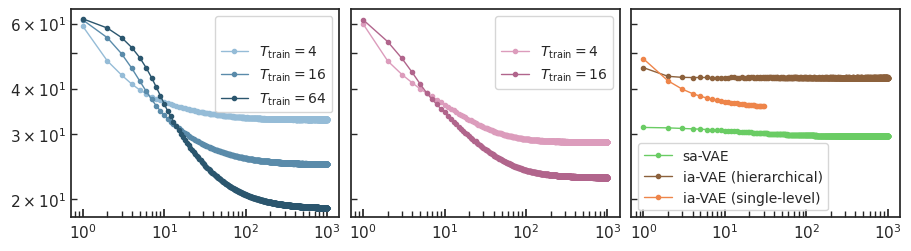

In [14]:
fig, axes = create_figure(1, 3, (9.0, 2.4), sharex='all', sharey='all')

for i, (archi, selected) in enumerate(selected_models.items()):
    for item in selected:
        name = f'MNIST_<jacob|{archi}>_{item}'
        _df = df.loc[df['name'] == name]
        if not len(_df):
            continue
        x2p = _df['mse'].to_numpy()
    
        ax = axes[i]
        label = r"$T_\text{train} = $"
        label += str(_df['n_iters_train'].unique().item())
        ax = convergence_subplot(ax, x2p, label, color=pal[archi][item], legend_title=' ', legend=True)
        ax.tick_params(direction='in', which='both')

ax = axes[2]
for label, x2p in mse_outside.items():
    ax = convergence_subplot(ax, x2p[1:], label, color=pal_models[label], legend=True)
ax.tick_params(direction='in', which='both')

# axes[0].tick_params(axis='y', pad=-28)

In [15]:
fig.savefig(pjoin(fig_dir, 'convergence_mse_mnist2omni.pdf'), **kws_fig)

In [16]:
_df = df.loc[df['name'] == 'MNIST_<jacob|mlp>_(64,24.0)']
_df['mse'][-3:].to_numpy()

array([18.910858, 18.909151, 18.908768], dtype=float32)

In [17]:
_df = df.loc[df['name'] == 'MNIST_<jacob|conv>_(16,8.0)']
_df['mse'][-3:].to_numpy()

array([22.917616, 22.86428 , 22.881382], dtype=float32)